In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import random

import halotools
from halotools.empirical_models import PrebuiltSubhaloModelFactory

In [3]:
import sys 
sys.path.append('MCMC/')
from functions import *

3.0rc1


In [4]:
config_directory = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/'

config_initial = parse_config(config_directory+'mcmc_config_Vmax_3.yaml')
config, cosmos_data, sim_data = initial_model(config_initial)

5SHMR+scatter (Vmax@Mpeak)


In [4]:
halo_data = sim_data['halocat'].halo_table

In [12]:
halo_data

halo_upid,halo_y,halo_x,halo_z,halo_Vmax@Mpeak,halo_rvir,halo_vy,halo_id,halo_vx,halo_mpeak,halo_vz,halo_mvir,halo_hostid,halo_mvir_host_halo
int64,float32,float32,float32,float64,float32,float32,int64,float32,float32,float32,float32,int64,float32
-1,43.1197,36.04457,18.14896,999.86,1.207201,64.9,2404371171,21.07,162700000000000.0,-118.07,162700000000000.0,2404371171,162700000000000.0
2404371171,43.78071,35.53276,18.6678,40.06,0.037709,596.8,2404371172,-12.44,6819000000.0,484.04,4959000000.0,2404371171,162700000000000.0
2404371171,43.79097,35.40477,17.89662,35.48,0.035187,215.19,2404371173,-949.14,5889000000.0,-214.14,4029000000.0,2404371171,162700000000000.0
2404371171,43.65819,35.40134,17.56539,39.84,0.031128,167.72,2404371174,-217.95,5734000000.0,-795.51,2789000000.0,2404371171,162700000000000.0
2404371171,42.74515,35.22659,18.61028,30.83,0.029292999,-681.13,2404371175,-593.36,3254000000.0,-213.05,2324000000.0,2404371171,162700000000000.0
2404371171,43.34295,35.84579,18.4178,119.86,0.022721,163.26,2404371177,377.35,73760000000.0,-1119.11,1085000000.0,2404371171,162700000000000.0
2404371171,43.06175,35.40682,18.02761,19.03,0.021583,1072.98,2404371178,957.65,1085000000.0,-633.85,929800000.0,2404371171,162700000000000.0
2404371171,43.18763,36.27704,18.30016,43.93,0.021583,-507.66,2404371179,410.62,4959000000.0,1374.05,929800000.0,2404371171,162700000000000.0
2404371171,43.62281,35.36304,18.34547,17.54,0.018855,87.78,2404371190,-620.88,929800000.0,-591.06,619900000.0,2404371171,162700000000000.0


# Chris code

In [14]:
# mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
# # mass_s_params = [-0.06, 1.08] #chris params
# mass_s_params = [-0.2/3., 1.2]  #felipe params
# mass_x_field = "halo_mvir"

In [5]:
param = [0.4, 0.2, 12.52, 10.91, 0.45, 0.6, 1.83]
chris_stellar_masses = get_chris_stellar_masses(param, config, sim_data)

# HALOTOOLS 

In [17]:
params = mass_s_params + mass_b_params #concatenate
params = [0.4,0.2]+mass_b_params

In [7]:
def get_halotools_stellar_masses(params, config, sim_data):
    sim_data['model'] = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'],
                                        scatter_abscissa=[12, 15],
                                        scatter_ordinates=[params[0], params[1]])

    for i, model_param in enumerate(config['param_labels']):
        sim_data['model'].param_dict[model_param] = params[i]

    # set redshift dependence to 0
    for i, model_param in enumerate(config['redshift_param_labels']):
        sim_data['model'].param_dict[model_param] = 0

    # populate mock
    # sim_data['model'].populate_mock(deepcopy(sim_data['halocat']))
    sim_data['model'].populate_mock(sim_data['halocat'])

    mock_galaxies = sim_data['model'].mock.galaxy_table
    mock_galaxies = mock_galaxies['x', 'y', 'z', 'stellar_mass']
    
    return np.log10(mock_galaxies['stellar_mass'])

In [19]:
halotools_stellar_masses = get_halotools_stellar_masses(params, config, sim_data)

# histograms 

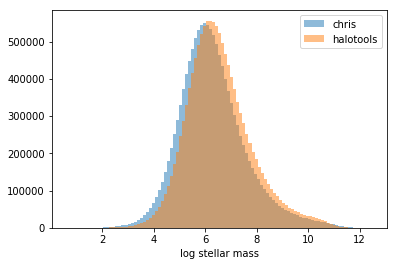

In [65]:
plt.hist(chris_stellar_masses, bins =100, alpha =0.5, label='chris')
plt.hist(halotools_stellar_masses, bins =100, alpha =0.5, label='halotools')

plt.legend()
plt.xlabel('log stellar mass')

plt.show()

In [66]:
print len(halotools_stellar_masses), len(chris_stellar_masses)

12939617 12939617


In [3]:
scatter_params = np.polyfit([12,15],[0.4,0.2],1)

In [5]:
scatter_params[0]

-0.06666666666666685

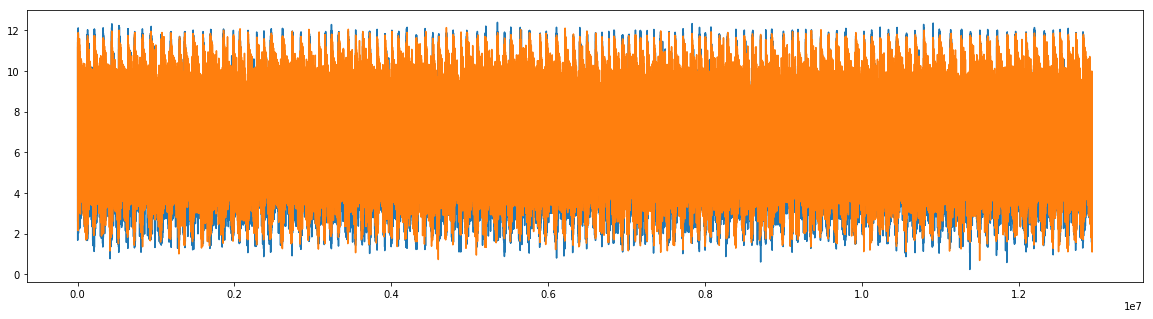

In [25]:
plt.figure(figsize=[20,5])
plt.plot(range(len(chris_stellar_masses)), chris_stellar_masses)
plt.plot(range(len(chris_stellar_masses)), halotools_stellar_masses)


In [28]:
mock_galaxies = sim_data['halocat'].halo_table['halo_x', 'halo_y', 'halo_z']
mock_galaxies['stellar_mass'] = chris_stellar_masses
mock_galaxies

halo_x,halo_y,halo_z,stellar_mass
float32,float32,float32,float64
36.04457,43.1197,18.14896,11.61379229121843
35.53276,43.78071,18.6678,5.717803842847478
35.40477,43.79097,17.89662,6.100653391039932
35.40134,43.65819,17.56539,4.4279617866960255
35.22659,42.74515,18.61028,5.54396695323049
35.84579,43.34295,18.4178,4.025752227906292
35.40682,43.06175,18.02761,3.260047561288997
36.27704,43.18763,18.30016,4.504874723632895
35.36304,43.62281,18.34547,3.515351158357194


In [30]:
sim_data['model'].mock.Lbox

array([250., 250., 250.])

## plot vmax vs m* for best fit parameters

USING CHRIS' CODE with halo_mvir
SMF computed
cut galaxies table 1127280
Ks_2sampResult(statistic=0.03727466832832549, pvalue=1.1968085037897633e-08)
Mock and COSMOS distributions don't match!
DS computed


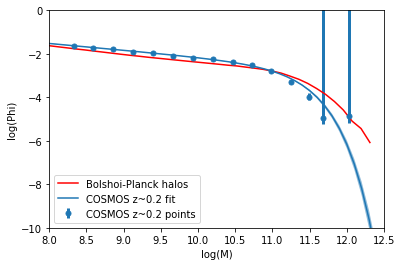

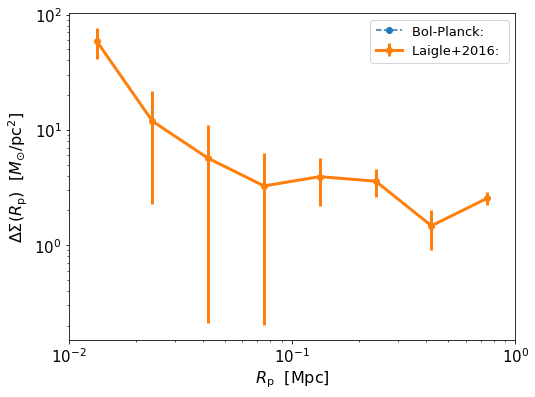

In [10]:
params =[0.4,0.2, 12.52, 10.91, 0.45, 0.6, 1.83]

# config['sim_mass_x_field'] = 'halo_Vmax@Mpeak'
config['sim_mass_x_field'] = 'halo_mvir'
config['sim_halotools'] = False

plot_from_params(params, config, cosmos_data, sim_data)

## Chris Vmax@Mpeak 

USING CHRIS' CODE with halo_Vmax@Mpeak
SMF computed
cut galaxies table 682855
Too few mock dwarfs!
DS computed


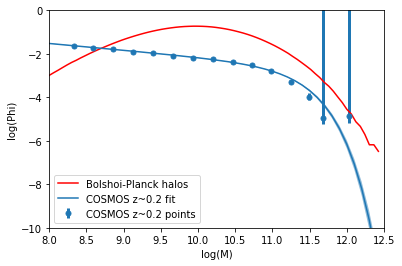

/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


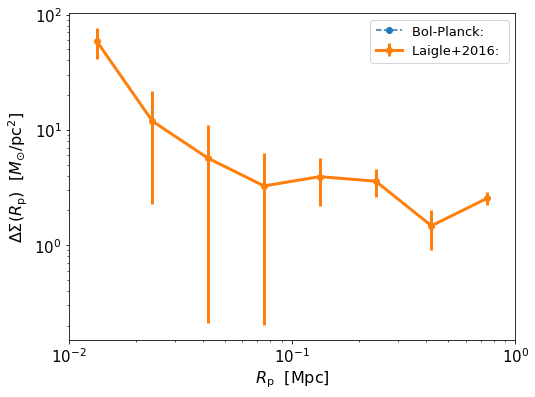

In [6]:
Vmax_params = [0.4,0.2, 2.4, 10.91, 0.45, 0.3, 0.2]
chris_stellar_masses = get_chris_stellar_masses(Vmax_params, config, sim_data)

config['sim_mass_x_field'] = 'halo_Vmax@Mpeak'
config['sim_halotools'] = False
plot_from_params(Vmax_params, config, cosmos_data, sim_data)

## Halotools

USING HALOTOOLS with halo_mvir
mock.populate
{u'smhm_beta_0': 0.45, u'smhm_delta_0': 0.6, u'smhm_m0_0': 10.91, u'smhm_m1_a': 0, u'smhm_m0_a': 0, u'smhm_beta_a': 0, u'smhm_gamma_0': 1.83, u'smhm_gamma_a': 0, u'smhm_m1_0': 12.52, u'scatter_model_param2': 0.2, u'smhm_delta_a': 0, u'scatter_model_param1': 0.4}
SMF computed
cut galaxies table 1451018
Ks_2sampResult(statistic=0.003805914314707004, pvalue=0.9999699161579839)
DS computed


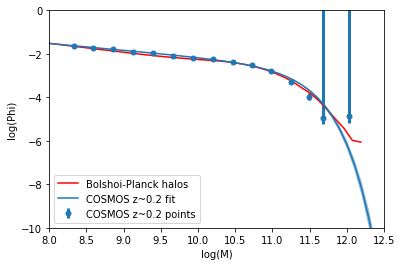

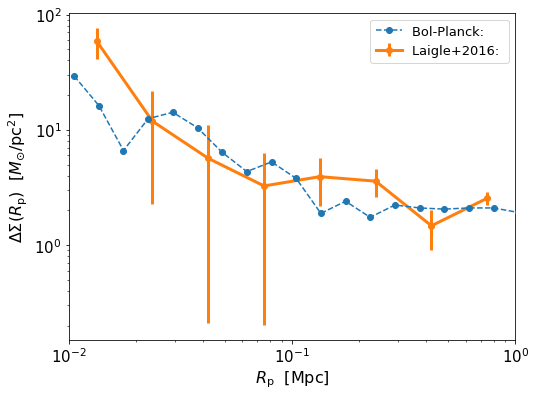

In [8]:
Mvir_params =[0.4,0.2, 12.52, 10.91, 0.45, 0.6, 1.83]
halotools_stellar_masses = get_halotools_stellar_masses(Mvir_params, config, sim_data)
config['sim_halotools'] = True
plot_from_params(Mvir_params, config, cosmos_data, sim_data)

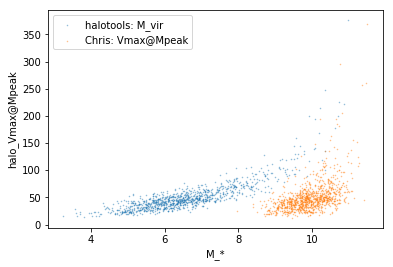

In [9]:
downsampled_halotools = random.sample(zip(halotools_stellar_masses, sim_data['halocat'].halo_table['halo_Vmax@Mpeak']), 1000)
downsampled_chris = random.sample(zip(chris_stellar_masses, sim_data['halocat'].halo_table['halo_Vmax@Mpeak']), 1000)

plt.scatter([a[0] for a in downsampled_halotools], [a[1] for a in downsampled_halotools],
          alpha=0.5, s=1, marker='.', label='halotools: M_vir')
plt.scatter([a[0] for a in downsampled_chris], [a[1] for a in downsampled_chris],
          alpha=0.5, s=1, marker='.', label = 'Chris: Vmax@Mpeak')

# plt.axvline(12.52, color='r')
# plt.ylim([0,500])
# plt.xlim([8,13])
plt.xlabel('M_*')
plt.ylabel('halo_Vmax@Mpeak')
plt.legend()
plt.show()